In [ ]:
# Автоматическая перезагрузка модулей при изменении
# Позволяет обновлять код в helper.py, plots.py, nlp.py без перезапуска ядра
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Импорт библиотек для классического ML и нейронных сетей
import pandas as pd
import numpy as np
import random

# Импорт sklearn для классических алгоритмов
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
from lightgbm import LGBMClassifier

# Импорт TensorFlow/Keras для нейронных сетей
import tensorflow as tf
from tensorflow.keras.utils import set_random_seed, to_categorical
from tensorflow.keras.regularizers import l2 as l2_reg
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, SimpleRNN, Dense, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.config.experimental import list_physical_devices
from tensorflow.keras.layers import LSTM

# Пользовательские модули
from helper import *        # вспомогательные функции
from plots import *         # функции визуализации
from nlp import *          # функции обработки естественного языка
from transformers import * # функции для работы с трансформерами
from keras_helper import * # функции для работы с Keras

In [90]:
# Проверка GPU
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"GPU доступен: {len(gpus)} устройств")
else:
    print("GPU недоступен, используется CPU")


GPU доступен: 1 устройств


In [ ]:
# Фиксация состояния генератора псевдослучайных чисел для воспроизводимости
# Критически важно для машинного обучения - результаты должны быть воспроизводимы
SEED = 42 # можно указать любое число
np.random.seed(SEED)  # для numpy операций
random.seed(SEED)     # для стандартного модуля random
set_random_seed(SEED) # для TensorFlow/Keras

In [ ]:
# Загружаем предобработанные данные
df = pd.read_csv('data/data_preprocessed.csv')

## 1. Препроцессинг и бейслайн

**Цель:** Подготовить данные для обучения нейронных сетей и создать baseline модель для сравнения.
Нейронные сети требуют специальной предобработки - объединения текстов и создания последовательностей.

In [ ]:
# Создаем копию данных для предобработки
df_preprocessed = df.copy()

# Удаляем ненужный столбец с индексами
df_preprocessed.drop(columns=['Unnamed: 0'], inplace=True)

# Преобразуем целевую переменную в числовой формат
df_preprocessed['is_data_science'] = pd.to_numeric(df_preprocessed['is_data_science'])

# Удаляем неинформативные записи с описанием "Unknown"
df_preprocessed = df_preprocessed[df_preprocessed['description'] != 'Unknown'] 

# Токенизируем тексты с помощью tiktoken (токенизатор GPT)
df_preprocessed['title'] = df_preprocessed['title'].apply(tokenize_tiktoken)
df_preprocessed['description'] = df_preprocessed['description'].apply(tokenize_tiktoken)

# Удаляем стоп-слова, но оставляем пунктуацию (она информативна для markdown)
df_preprocessed[['description', 'title']] = df_preprocessed[['description', 'title']].map(lambda tokens: filter_tokens(
    tokens, 
    remove_stopwords=True, 
    remove_punct_tokens=False,
    lowercase_for_counting=True
))


In [ ]:
# Разделяем данные на признаки (X) и целевую переменную (y)
X, y = divide_data(df_preprocessed, 'is_data_science')

In [ ]:
# Создаем baseline модель LGBM для сравнения с нейронными сетями
lgbm_classifier = LGBMClassifier(random_state=SEED, verbose=-1)

In [ ]:
# Настраиваем кросс-валидацию с 3 фолдами (меньше для ускорения обучения нейронных сетей)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

In [ ]:
# Создаем пайплайн для векторизации текстов (для baseline модели)
count_vectorizer_preprocessor = Pipeline([
    ('vectorizer', ColumnTransformer(
        [
            ('title_vectorizer', CountVectorizer(analyzer=lambda x: x, min_df=50, dtype=np.float32), 'title'),
            ('description_vectorizer', CountVectorizer(analyzer=lambda x: x, min_df=50, dtype=np.float32), 'description'),
        ],
        remainder='passthrough', 
        verbose_feature_names_out=True
    )),
])

c:\Apps\miniconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Apps\miniconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Apps\miniconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Apps\miniconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Apps\miniconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted w

<Figure size 1500x600 with 0 Axes>

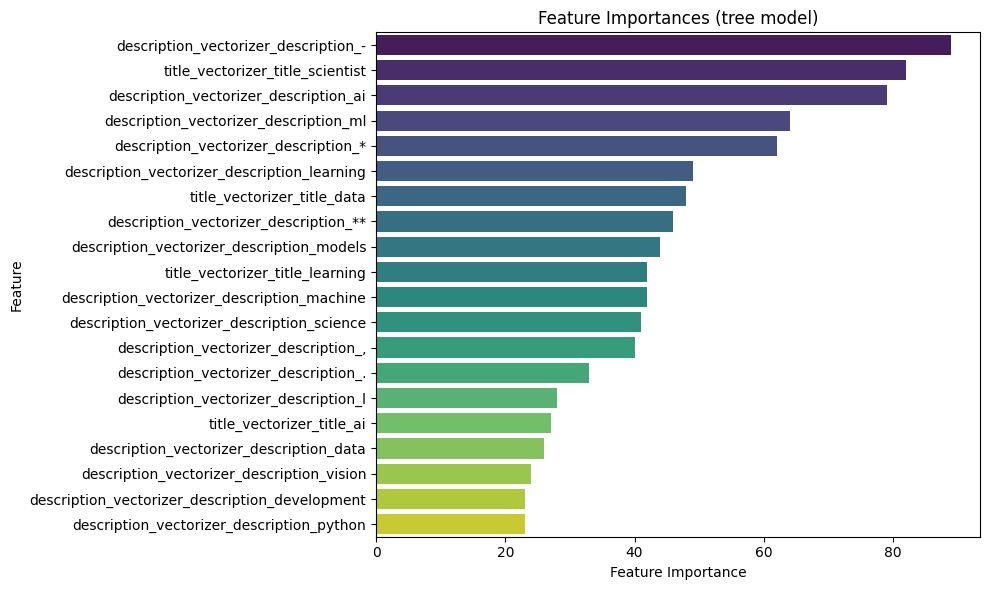

In [ ]:
# Обучаем baseline модель LGBM для сравнения с нейронными сетями
# baseline_metrics = train_evaluate_models_cv(
#     models=models,
#     X=X,
#     y=y,
#     preprocessor=count_vectorizer_preprocessor,
#     cv=cv,
#     seed=SEED,
#     plot_feature_importance=False
# )

baseline_metrics = train_evaluate_model_cv(
    model=lgbm_classifier,
    model_name='LGBMClassifier',
    X=X,
    y=y,
    preprocessor=count_vectorizer_preprocessor,
    cv=cv,
    seed=SEED
)


In [ ]:
# Выводим метрики baseline модели
baseline_metrics

ClassificationMetrics(name='LGBMClassifier', training_time=1.8666634559631348, estimators=None, roc_auc=0.9598282054621476, f1_score=0.8863373191609051, precision=0.8881762133676956, recall=0.8860166711258902, accuracy=0.8912996174900938, confusion_matrix=None, classification_report=None, roc_curve=None)

## Препроцессинг перед использованием нейросетей

**Цель:** Подготовить данные для нейронных сетей, которые работают с последовательностями токенов.
Нейронные сети не могут напрямую работать с несколькими отдельными текстами, поэтому объединяем их.

In [ ]:
# Параметры для нейронных сетей
MAX_NUM_WORDS = 100        # максимальное количество уникальных слов в словаре
MAX_SEQUENCE_LENGTH = 600  # максимальная длина последовательности токенов

In [ ]:
# Нейронные сети не могут принимать на вход два разных вектора, поэтому объединяем их
# Конкатенируем заголовок и описание в один текст для создания единой последовательности
df_preprocessed['title_and_description'] = df_preprocessed['title'] + df_preprocessed['description']
df_preprocessed = df_preprocessed.drop(columns=['title', 'description'])

In [ ]:
# Разделяем данные на признаки (объединенные тексты) и целевую переменную
X, y = divide_data(df_preprocessed, 'is_data_science')

In [ ]:
# Демонстрация процесса предобработки для нейронных сетей
X_lol = X.copy()

# Отбираем топ-100 наиболее важных токенов для создания словаря
feature_selector = NgramFeatureSelector(top_k=MAX_NUM_WORDS)
X_lol['title_and_description'] = feature_selector.fit_transform(X_lol['title_and_description'])

In [ ]:
# Преобразуем токены в последовательности чисел для нейронных сетей
vect = SequenceVectorizer(min_frequency=50, max_sequence_length=MAX_SEQUENCE_LENGTH, pad_left=False)
X_lol = vect.fit_transform(X_lol['title_and_description'])

In [ ]:
# Результат: каждая строка - это последовательность индексов токенов
# Длина каждой последовательности <= MAX_SEQUENCE_LENGTH (600)
X_lol

array([[ 7,  9, 13, ...,  0,  0,  0],
       [19, 46, 27, ...,  0,  0,  0],
       [22, 16, 27, ...,  0,  0,  0],
       ...,
       [17, 27,  2, ...,  0,  0,  0],
       [17, 27,  2, ...,  0,  0,  0],
       [17, 27,  3, ...,  0,  0,  0]])

In [ ]:
# Создаем пайплайн предобработки для нейронных сетей
RNN_preprocessor = Pipeline([
    ('token_selector', NgramFeatureSelector(top_k=100)),  # отбираем топ-100 важных токенов
    ('seq_vec', SequenceVectorizer(                       # преобразуем в последовательности
        min_frequency=50,                                 # минимальная частота токена
        max_sequence_length=MAX_SEQUENCE_LENGTH,          # максимальная длина последовательности
        pad_left=False                                    # дополнение справа (стандарт для RNN)
    ))
])

## 2. RNN (Рекуррентная нейронная сеть)

**Логика:** RNN обрабатывает последовательности токенов слева направо, сохраняя информацию о предыдущих токенах.
Используем Bidirectional RNN для анализа контекста в обе стороны. Это базовая архитектура для сравнения с более сложными.

Fold 1
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 600, 10)           1010      
                                                                 
 bidirectional_3 (Bidirectio  (None, 16)               304       
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 [==============================] - 11s 2s/step - loss: 0.6400 - auc: 0.6957
Epoch 2/50
5/5 [==============================] - 8s 2s/step - loss: 0.5174 - auc: 0.9039
Epoch 3/50
5/5 [==============================] - 7s 1s/step -

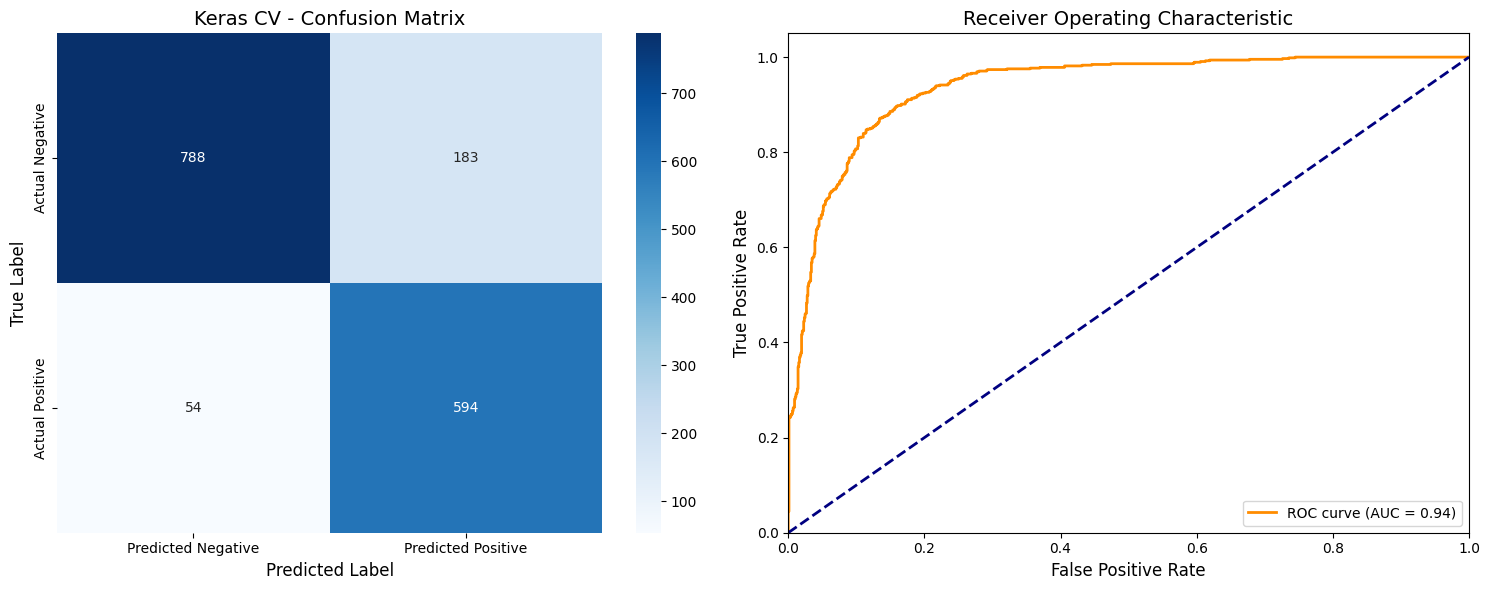

In [ ]:
# Лучший AUC score: 0.945

# Гиперпараметры для RNN модели
LEARNING_RATE = 0.01        # скорость обучения
BATCH_SIZE = 256           # размер батча
RNN_UNITS = 8              # количество нейронов в RNN слое
EMBEDDING_DIM = 10         # размерность эмбеддингов слов

DROPOUT_RATE = 0.5         # dropout для предотвращения переобучения
RECCURENT_DROPOUT_RATE = 0 # dropout для рекуррентных соединений
DROPOUT_LAYER_RATE = 0.0   # dropout для дополнительных слоев

REGULARIZATION_STRENGTH = 0.0001  # сила L2 регуляризации

# Функция создания RNN модели
def build_rnn_model():
    model = Sequential([
        # Слой эмбеддингов: преобразует индексы токенов в плотные векторы
        Embedding(input_dim=MAX_NUM_WORDS + 1, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH,
                    embeddings_regularizer=l2_reg(REGULARIZATION_STRENGTH)),
        
        # Двунаправленная RNN: анализирует последовательность в обе стороны
        Bidirectional(SimpleRNN(RNN_UNITS, dropout=DROPOUT_RATE, recurrent_dropout=RECCURENT_DROPOUT_RATE, return_sequences=False)),
        
        # Выходной слой для бинарной классификации
        Dense(1, activation="sigmoid")
    ])
    
    # Компилируем модель с оптимизатором Adam
    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["AUC"])
    return model

# Параметры обучения
fit_params = dict(
    epochs=50,  # максимальное количество эпох
    batch_size=BATCH_SIZE,
    callbacks=[EarlyStopping(monitor='auc', mode='max', patience=5, restore_best_weights=True)],  # ранняя остановка
    verbose=1
)

# Обучаем RNN модель с кросс-валидацией
rnn_metrics = cross_validate_model(
    model_builder=build_rnn_model,
    X=X['title_and_description'],
    y=y,
    preprocessor=RNN_preprocessor,
    cv=cv,
    fit_params=fit_params
)

In [ ]:
# Результаты обучения RNN модели
rnn_metrics

ClassificationMetrics(name=None, training_time=543.2740826999998, estimators=[{'preprocessor': Pipeline(steps=[('token_selector', NgramFeatureSelector()),
                ('seq_vec',
                 SequenceVectorizer(max_sequence_length=600, min_frequency=50,
                                    pad_left=False))]), 'model': <keras.engine.sequential.Sequential object at 0x0000023E04DB7400>}, {'preprocessor': Pipeline(steps=[('token_selector', NgramFeatureSelector()),
                ('seq_vec',
                 SequenceVectorizer(max_sequence_length=600, min_frequency=50,
                                    pad_left=False))]), 'model': <keras.engine.sequential.Sequential object at 0x0000023E0384D370>}, {'preprocessor': Pipeline(steps=[('token_selector', NgramFeatureSelector()),
                ('seq_vec',
                 SequenceVectorizer(max_sequence_length=600, min_frequency=50,
                                    pad_left=False))]), 'model': <keras.engine.sequential.Sequential obj

## 3. CNN (Сверточная нейронная сеть)

**Логика:** CNN применяет сверточные фильтры к последовательности токенов, выявляя локальные паттерны.
GlobalMaxPooling1D выбирает наиболее важные признаки из всей последовательности.
CNN часто работают быстрее RNN и могут выявлять n-граммы эффективнее.

Fold 1
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 600, 20)           2020      
                                                                 
 conv1d_3 (Conv1D)           (None, 598, 8)            488       
                                                                 
 global_max_pooling1d_3 (Glo  (None, 8)                0         
 balMaxPooling1D)                                                
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,517
Trainable params: 2,517
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
9/9 [==============================] - 1s 15ms/step - loss: 0.6447 - auc: 0.7146
Epoch 2/50
9/9 [===

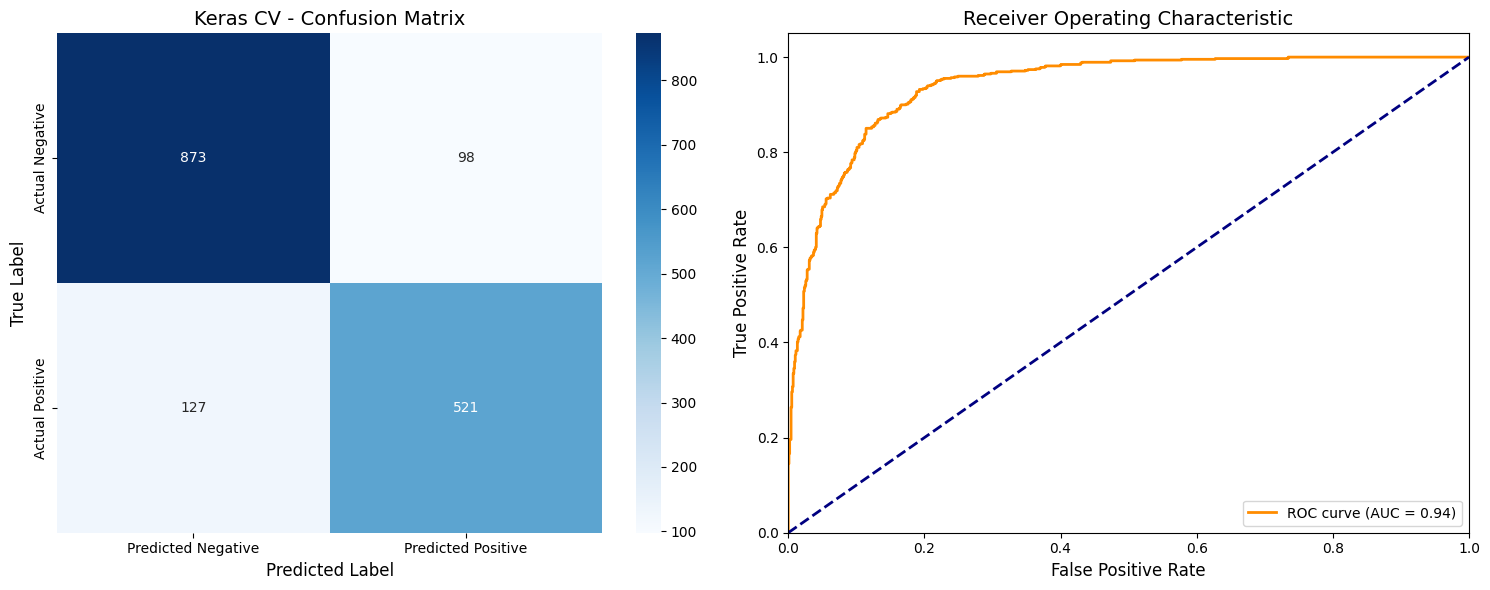

In [ ]:
# Гиперпараметры для CNN модели
LEARNING_RATE = 0.01
BATCH_SIZE = 128          # меньший батч для CNN
FILTERS = 8               # количество сверточных фильтров
KERNEL_SIZE = 3           # размер ядра свертки (3-граммы)
EMBEDDING_DIM = 20        # больше размерность эмбеддингов для CNN

DROPOUT_RATE = 0.5
DROPOUT_LAYER_RATE = 0.0

REGULARIZATION_STRENGTH = 0.01

# Функция создания CNN модели
def build_cnn_model():
    model = Sequential([
        # Слой эмбеддингов
        Embedding(input_dim=MAX_NUM_WORDS + 1, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH,
                  embeddings_regularizer=l2_reg(REGULARIZATION_STRENGTH)),
        
        # Сверточный слой: выявляет локальные паттерны (n-граммы)
        Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation='relu'),
        
        # Глобальное максимальное пулирование: выбирает наиболее важные признаки
        GlobalMaxPooling1D(),
        
        # Выходной слой для бинарной классификации
        Dense(1, activation="sigmoid")
    ])
    
    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["AUC"])
    return model

# Параметры обучения
fit_params = dict(
    epochs=50,
    batch_size=BATCH_SIZE,
    callbacks=[EarlyStopping(monitor='auc', mode='max', patience=5, restore_best_weights=True)],
    verbose=1
)

# Обучаем CNN модель с кросс-валидацией
cnn_metrics = cross_validate_model(
    model_builder=build_cnn_model,
    X=X['title_and_description'],
    y=y,
    preprocessor=RNN_preprocessor,  # Используем тот же препроцессор, что и для RNN
    cv=cv,
    fit_params=fit_params
)

In [ ]:
# Результаты обучения CNN модели
cnn_metrics


ClassificationMetrics(name=None, training_time=10.910586300000432, estimators=[{'preprocessor': Pipeline(steps=[('token_selector', NgramFeatureSelector()),
                ('seq_vec',
                 SequenceVectorizer(max_sequence_length=600, min_frequency=50,
                                    pad_left=False))]), 'model': <keras.engine.sequential.Sequential object at 0x0000023DB2271340>}, {'preprocessor': Pipeline(steps=[('token_selector', NgramFeatureSelector()),
                ('seq_vec',
                 SequenceVectorizer(max_sequence_length=600, min_frequency=50,
                                    pad_left=False))]), 'model': <keras.engine.sequential.Sequential object at 0x0000023E04D434F0>}, {'preprocessor': Pipeline(steps=[('token_selector', NgramFeatureSelector()),
                ('seq_vec',
                 SequenceVectorizer(max_sequence_length=600, min_frequency=50,
                                    pad_left=False))]), 'model': <keras.engine.sequential.Sequential ob

Fold 1
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 600, 20)           2020      
                                                                 
 bidirectional_6 (Bidirectio  (None, 16)               1856      
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,893
Trainable params: 3,893
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
9/9 [==============================] - 4s 98ms/step - loss: 0.6348 - auc: 0.7076
Epoch 2/50
9/9 [==============================] - 1s 97ms/step - loss: 0.4583 - auc: 0.8987
Epoch 3/50
9/9 [==============================] - 1s 102ms

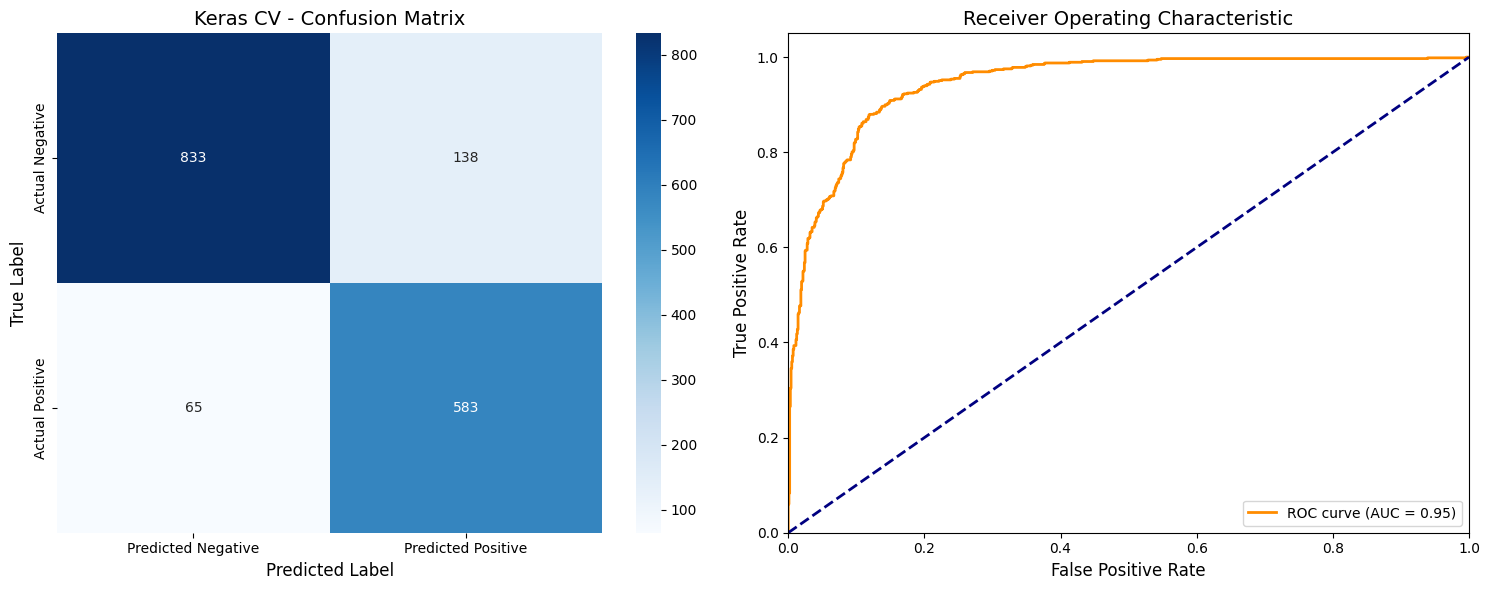

In [ ]:
# Гиперпараметры для LSTM модели
LEARNING_RATE = 0.01
BATCH_SIZE = 128
LSTM_UNITS = 8            # количество нейронов в LSTM слое
EMBEDDING_DIM = 20

DROPOUT_RATE = 0.5
RECCURENT_DROPOUT_RATE = 0
DROPOUT_LAYER_RATE = 0.0

REGULARIZATION_STRENGTH = 0.01

# Функция создания LSTM модели
def build_lstm_model():
    model = Sequential([
        # Слой эмбеддингов
        Embedding(input_dim=MAX_NUM_WORDS + 1, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH,
                  embeddings_regularizer=l2_reg(REGULARIZATION_STRENGTH)),
        
        # Двунаправленная LSTM: более сложная архитектура для работы с долгосрочными зависимостями
        Bidirectional(LSTM(LSTM_UNITS, dropout=DROPOUT_RATE, recurrent_dropout=RECCURENT_DROPOUT_RATE, return_sequences=False)),
        
        # Выходной слой для бинарной классификации
        Dense(1, activation="sigmoid")
    ])
    
    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["AUC"])
    return model

# Параметры обучения
fit_params = dict(
    epochs=50,
    batch_size=BATCH_SIZE,
    callbacks=[EarlyStopping(monitor='auc', mode='max', patience=5, restore_best_weights=True)],
    verbose=1
)

# Обучаем LSTM модель с кросс-валидацией
lstm_metrics = cross_validate_model(
    model_builder=build_lstm_model,
    X=X['title_and_description'],
    y=y,
    preprocessor=RNN_preprocessor,  # Используем тот же препроцессор
    cv=cv,
    fit_params=fit_params
)

In [ ]:
# Результаты обучения LSTM модели
lstm_metrics


ClassificationMetrics(name=None, training_time=71.62649560000136, estimators=[{'preprocessor': Pipeline(steps=[('token_selector', NgramFeatureSelector()),
                ('seq_vec',
                 SequenceVectorizer(max_sequence_length=600, min_frequency=50,
                                    pad_left=False))]), 'model': <keras.engine.sequential.Sequential object at 0x0000023DF9FE1EE0>}, {'preprocessor': Pipeline(steps=[('token_selector', NgramFeatureSelector()),
                ('seq_vec',
                 SequenceVectorizer(max_sequence_length=600, min_frequency=50,
                                    pad_left=False))]), 'model': <keras.engine.sequential.Sequential object at 0x0000023E01F2C1F0>}, {'preprocessor': Pipeline(steps=[('token_selector', NgramFeatureSelector()),
                ('seq_vec',
                 SequenceVectorizer(max_sequence_length=600, min_frequency=50,
                                    pad_left=False))]), 'model': <keras.engine.sequential.Sequential obj

Fold 1
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 600, 100)          2000200   
                                                                 
 conv1d_6 (Conv1D)           (None, 598, 8)            2408      
                                                                 
 global_max_pooling1d_6 (Glo  (None, 8)                0         
 balMaxPooling1D)                                                
                                                                 
 dense_15 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,002,617
Trainable params: 2,417
Non-trainable params: 2,000,200
_________________________________________________________________
Epoch 1/50
9/9 [==============================] - 1s 13ms/step - loss: 0.5148 - auc: 0.8109
Epoch 

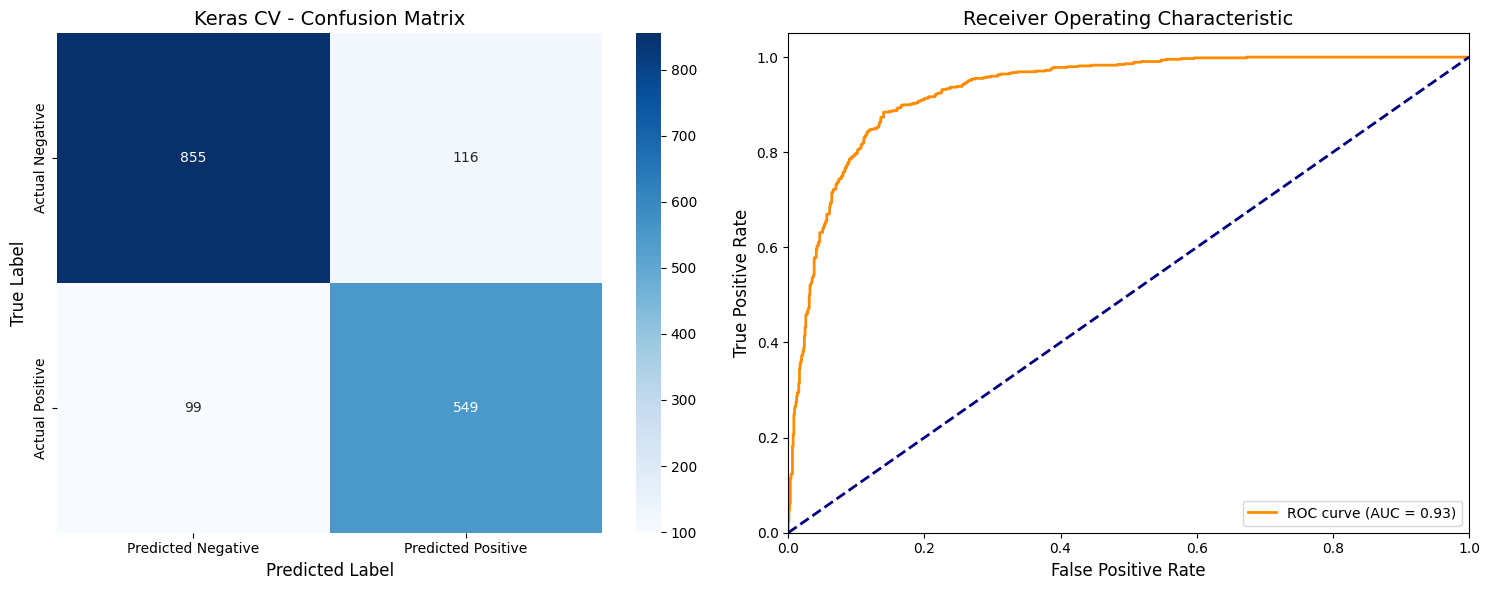

In [ ]:
# Загружаем предобученные GloVe эмбеддинги для улучшения качества модели
from typing import Dict, Tuple
import numpy as np

# Параметры GloVe эмбеддингов
GLOVE_DIM: int = 100           # размерность GloVe векторов
GLOVE_MAX_VOCAB: int = 20000   # количество GloVe слов (исключая PAD/OOV)
GLOVE_PATH: str = 'glove.6B.100d.txt'  # путь к файлу GloVe

def _load_glove_fixed_vocab(path: str, embedding_dim: int, max_words: int) -> Tuple[dict, np.ndarray]:
    """Загружает GloVe эмбеддинги и создает словарь с фиксированным размером"""
    vocab: Dict[str, int] = {'<PAD>': 0, '<OOV>': 1}  # специальные токены
    matrix = [np.zeros(embedding_dim, dtype='float32'), np.zeros(embedding_dim, dtype='float32')]

    added = 0
    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            if added >= max_words:
                break
            parts = line.rstrip().split(' ')
            if len(parts) < embedding_dim + 1:
                continue
            token = parts[0]
            if token in vocab:  # пропускаем дубликаты
                continue
            vec = np.asarray(parts[1:], dtype='float32')
            if vec.shape[0] != embedding_dim:
                continue
            # присваиваем следующий ID начиная с 2
            idx = len(vocab)
            vocab[token] = idx
            matrix.append(vec)
            added += 1

    embedding_matrix = np.vstack(matrix)
    return vocab, embedding_matrix

# Загружаем GloVe эмбеддинги
_glove_vocab, _glove_matrix = _load_glove_fixed_vocab(GLOVE_PATH, GLOVE_DIM, GLOVE_MAX_VOCAB)

# Создаем препроцессор с фиксированным словарем GloVe
GLOVE_preprocessor = Pipeline([
    ('token_selector', NgramFeatureSelector(top_k=MAX_NUM_WORDS)),
    ('seq_vec', SequenceVectorizer(
        vocabulary=_glove_vocab,  # используем фиксированный словарь
        max_sequence_length=MAX_SEQUENCE_LENGTH,
        pad_left=False,
    )),
])

# CNN с замороженными GloVe эмбеддингами
def build_cnn_glove_fixed_model():
    model = Sequential([
        # Слой эмбеддингов с предобученными GloVe весами (замороженными)
        Embedding(
            input_dim=_glove_matrix.shape[0],
            output_dim=_glove_matrix.shape[1],
            input_length=MAX_SEQUENCE_LENGTH,
            weights=[_glove_matrix],
            trainable=False,  # замораживаем веса эмбеддингов
        ),
        Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(1, activation='sigmoid'),
    ])
    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['AUC'])
    return model

# Обучаем CNN с GloVe эмбеддингами
cnn_glove_fixed_metrics = cross_validate_model(
    model_builder=build_cnn_glove_fixed_model,
    X=X['title_and_description'],
    y=y,
    preprocessor=GLOVE_preprocessor,
    cv=cv,
    fit_params=fit_params,
)

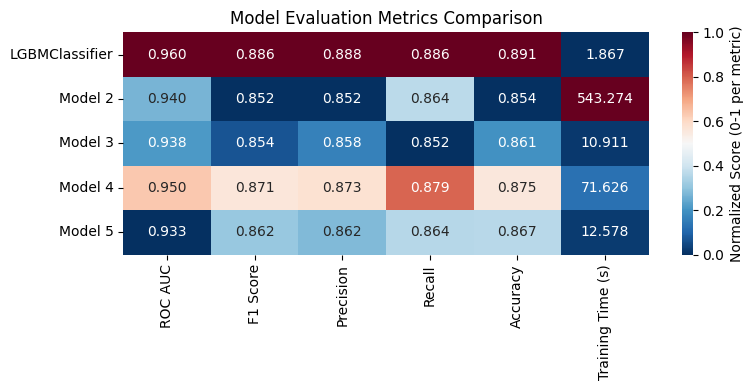

In [ ]:
# Сравниваем результаты всех обученных моделей
# Тепловая карта покажет, какая модель показала наилучшие результаты
plot_metrics_heatmap(
    metrics=[
        baseline_metrics,      # LGBM baseline
        rnn_metrics,          # RNN нейронная сеть
        cnn_metrics,          # CNN нейронная сеть
        lstm_metrics,         # LSTM нейронная сеть
        cnn_glove_fixed_metrics  # CNN с предобученными GloVe эмбеддингами
    ],
)